In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from warnings import filterwarnings
# filterwarnings('ignore')

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_processed.csv')

# Males/Females only to simplify the data
data = data[data.gender < 3]
data['gender'] = np.where(data['gender'] == 1, 'male', 'female')

print('Data shape:', data.shape)
print('\nGender ratio:')
print(data.gender.value_counts(normalize=True))

Data shape: (13078, 125)

Gender ratio:
female    0.591681
male      0.408319
Name: gender, dtype: float64


In [3]:
data.head()

,I can easily tell if someone else wants to enter a conversation.,I prefer animals to humans.,I try to keep up with the current trends and fashions.,"I find it difficult to explain to others things that I understand easily, when they don't understand it first time.",I dream most nights.,I really enjoy caring for other people.,I try to solve my own problems rather than discussing them with others.,I find it hard to know what to do in a social situation.,I am at my best first thing in the morning.,People often tell me that I went too far in driving my point home in a discussion.,...,I do not read legal documents very carefully.,I am not interested in understanding how wireless communication works.,I am curious about life on other planets.,"When I travel, I like to learn specific details about the culture of the place I am visiting.",I do not care to know the names of the plants I see.,EQ,SQ,accuracy,gender,age
0,3,1,3,2,4,3,1,3,1,3,...,2,1,4,4,3,37,49,80,male,39
1,4,3,3,2,2,2,2,3,4,4,...,4,4,3,4,2,54,14,98,female,21
2,3,3,3,1,1,2,2,2,3,1,...,3,4,3,2,4,57,12,95,female,32
3,2,2,2,1,2,1,3,2,4,4,...,2,3,3,4,1,43,32,80,female,53
4,3,1,2,4,4,2,3,3,2,3,...,2,1,3,4,1,26,57,97,male,17


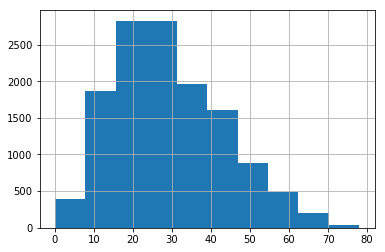

In [4]:
data['SQ'].hist()

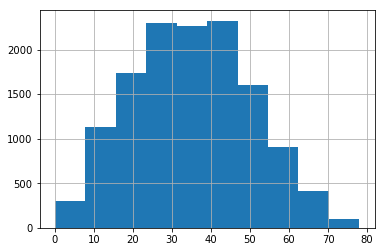

In [5]:
data['EQ'].hist()

In [6]:
df_gender = data.drop(['accuracy', 'age', 'EQ', 'SQ'], axis=1).groupby('gender').mean().T
df_gender['difference'] = (df_gender['male'] - df_gender['female'])/df_gender['male']

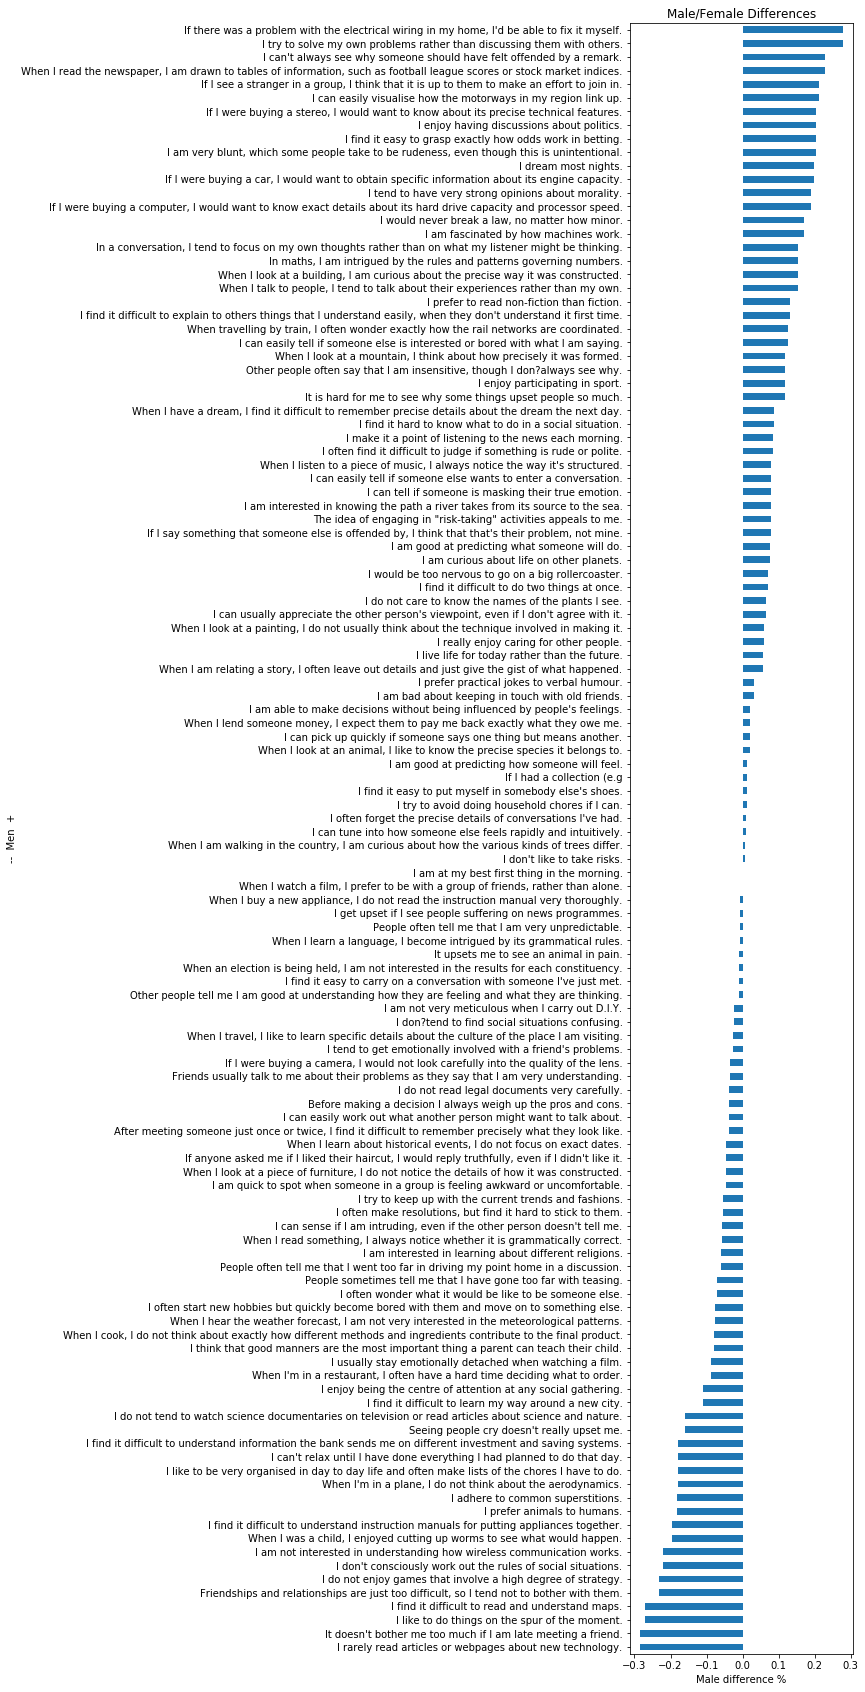

In [7]:
df_gender['difference'].sort_values().plot.barh(figsize=(4,30))
plt.title('Male/Female Differences')
plt.xlabel('Male difference %')
plt.ylabel('--  Men  +')

# Machine Learning

I was curious to see whether machine learning can tell men and women apart by how they answer these questions.

For actual machine learning problems, it's a good idea to pick a single metric and stick with it throughout the optimization process. It's also necessary to have a test set. But for this task, I'm going to do things a bit more casually.

- No train/test split (Cross-val score only)

- I'll use both ROC-AUC *and* accuracy as metrics. I like ROC-AUC for binary classification tasks (such as this one), because the data it provides is more nuanced. But to say the model predicts gender with X% accuracy is useful here too, so we'll look at that as well.

In [11]:
x = data[[i for i in data.numeric().columns if data[i].mean() < 5]].copy()
x['age'] = data['age'].copy()
y = np.where(data['gender'] == 'male', 1, 0)

# ROC-AUC

In [85]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {
    'max_depth': [4],
    'reg_lambda': np.arange(1.0, 1.31, .1),
    'n_estimators': [200]
}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=0,
       silent=True, subsample=1) 

Mean score: 0.855087234035
Std Dev:    0.00562671295652


# Accuracy

In [65]:
xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

cv = cross_val_score(xg, x, y, cv=4, scoring='accuracy')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.1000000000000001, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean score: 0.781847524189
Std Dev:    0.00538429051777


# TODO: PCA

In [19]:
print(x.shape[1], 'features')

121 features


In [17]:
from sklearn.decomposition import PCA
xpca = x.drop('age', axis=1)

for i in range(10,61,10):
    pca = PCA(n_components=i).fit(xpca)
    print(i, pca.explained_variance_ratio_.sum())

10 0.451201148034
20 0.606295365605
30 0.73076239968
40 0.83975289273
50 0.931464685162
60 1.0


So... it looks like we could actually cut the dimensionality in half. Let's try machine learning one more time.

In [21]:
xpca = PCA(n_components=60).fit_transform(xpca)

clf = XGBClassifier()
params = {
    'max_depth': [2,3,4],
    'reg_lambda': np.arange(1.0, 1.31, .1),
    'n_estimators': [200]
}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(xpca, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, xpca, y, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2000000000000002, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean score: 0.840327939787
Std Dev:    0.00826228184369


In [22]:
xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

cv = cross_val_score(xg, xpca, y, cv=4, scoring='accuracy')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2000000000000002, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean score: 0.771524856333
Std Dev:    0.00908666520201


The performance is definitely comparable. In scenarios like this, you can use the time saved with reduced dimensionality to search a wider variety of hyperparameters. But I won't do that here.

# TODO: Sort by controversy

# TODO: Factor analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis

for n in range(50,2,-1):
    data = data.select_dtypes(include=[np.number])
    factor = FactorAnalysis(n_components=n, random_state=1).fit(data)

    # Stick it in a dataframe
    factors = pd.DataFrame(factor.components_, columns=data.columns).T

    col_names = []
    for i in range(n):
        # We'll need non-zero factor values for our next
        # step, so we'll start counting at 1
        col_names.append('factor_' + str(i + 1))

    factors.columns = col_names

    data_new = pd.DataFrame()
    items = []
    for i in col_names:
        for k, v in zip(factors[i].index, factors[i]):
            if np.abs(v) > 0.2: # factor loading
                items.append((i,k,v))
    
    # This effectively counts the number of items in
    # each factor. 4 or more should make the factor reliable. 
    items = pd.DataFrame(items)
    group = items.groupby(0).count()
    if len(group[group >= 4].dropna()) == n:
        print(n, 'works!')
        break